# Preserving values of a derived multivariate quantity

In this example, we calculated the wind kinetic energy per unit mass from the wind components `u` and `v`. 
We compared the effect of lossy compression on the derived quantity and impact of applied safeguards. 


In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5 = ERA5.sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [ ]:
# Data manipulation to calculate the quanties
ERA5_KE = 0.5 * (ERA5["u"] ** 2 + ERA5["v"] ** 2)
ERA5_KE.attrs.update(long_name="wind kinetic energy per unit mass", units="m^{2} s^{-2}")

In [6]:
import copy


def plot_data(
    da: xr.DataArray,
    title_prefix="",
    title_postfix="",
    error=False,
    n_levels=256,
    cmap=None,
    divergence_point=None,
    levels=None,
    chart=None,
    **kwargs,
):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)

    units = None if error else UNITS.get(da.name, None)
    divergence_point = (
        divergence_point
        if divergence_point is not None
        else 0.0
        if error
        else DIVERGENCE_POINT.get(da.name, None)
    )

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=units or source.units,
        )
    )

    da_units = style.convert_units(da.values, source.units)

    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(
        levels
        if levels is not None
        else earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=n_levels,
        )
    )
    style._legend_kwargs["ticks"] = earthkit.plots.styles.levels.auto_range(
        da_units,
        divergence_point=divergence_point,
        n_levels=10,
    )

    style._kwargs.update(kwargs)

    # force the colourmap to coolwarm for error plots
    style._colors = cmap if cmap is not None else "coolwarm" if error else style._colors

    show = chart is None
    if chart is None:
        chart = earthkit.plots.Map()

    # quickplot with the modified style
    chart.quickplot(
        da,
        units=units,
        style=style,
    )

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    if show:
        chart.show()

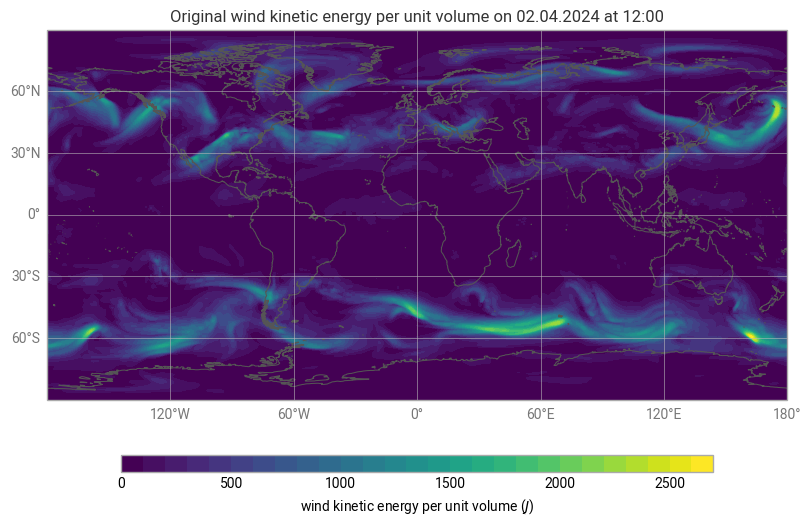

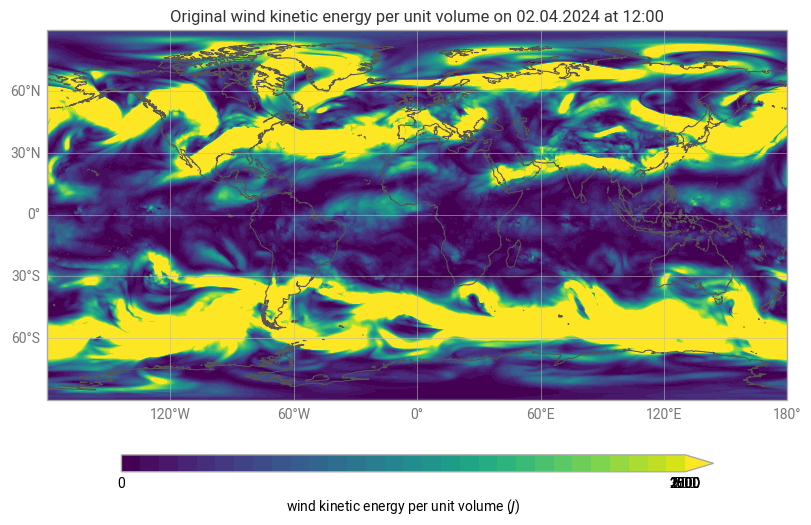

In [7]:
plot_data(
    ERA5_KE,
    levels=np.arange(0, 2700 + 1, 100),
    cmap="viridis",
    title_prefix="Original ",
)
plot_data(
    ERA5_KE,
    levels=np.arange(0, 300 + 1, 10),
    cmap="viridis",
    extend="max",
    title_prefix="Original ",
)

In [8]:
ERA5_UV = np.stack([ERA5["u"].values, ERA5["v"].values], axis=-1)
ERA5_UV.shape

(721, 1440, 2)

In [9]:
from numcodecs_wasm_zfp import Zfp

In [10]:
zfp = Zfp(mode="fixed-accuracy", tolerance=1)

In [11]:
ERA5_UV_zfp = zfp.decode(zfp.encode(ERA5_UV))

In [12]:
np.amax(np.abs(ERA5_UV_zfp - ERA5_UV))

np.float32(0.24009705)

In [13]:
ERA5_KE_zfp = ERA5_KE.copy(
    data=0.5 * air_mass * (ERA5_UV_zfp[..., 0] ** 2 + ERA5_UV_zfp[..., 1] ** 2)
)

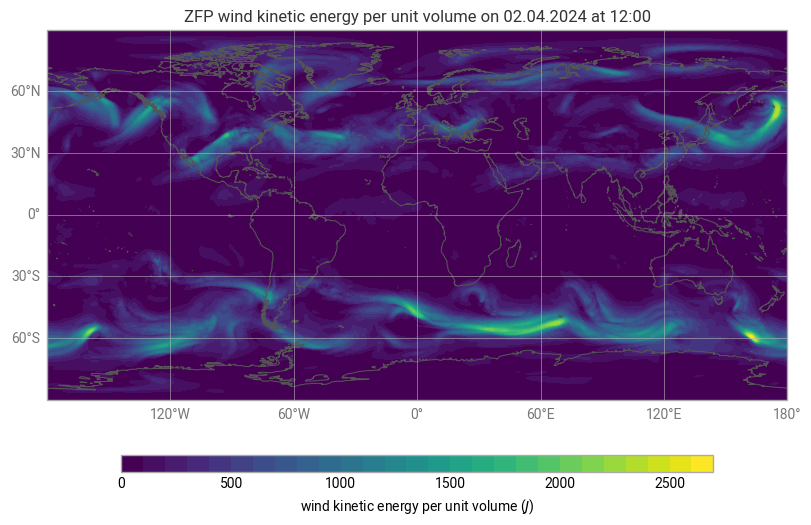

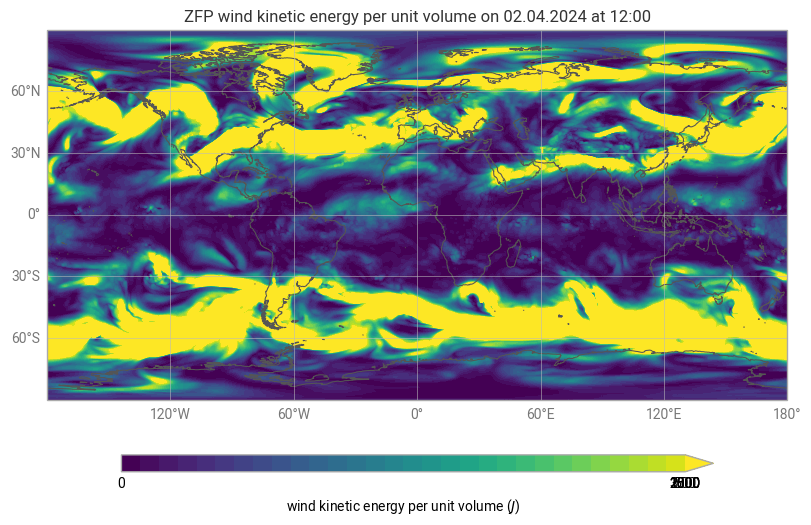

In [14]:
plot_data(
    ERA5_KE_zfp, levels=np.arange(0, 2700 + 1, 100), cmap="viridis", title_prefix="ZFP "
)
plot_data(
    ERA5_KE_zfp,
    levels=np.arange(0, 300 + 1, 10),
    cmap="viridis",
    extend="max",
    title_prefix="ZFP ",
)

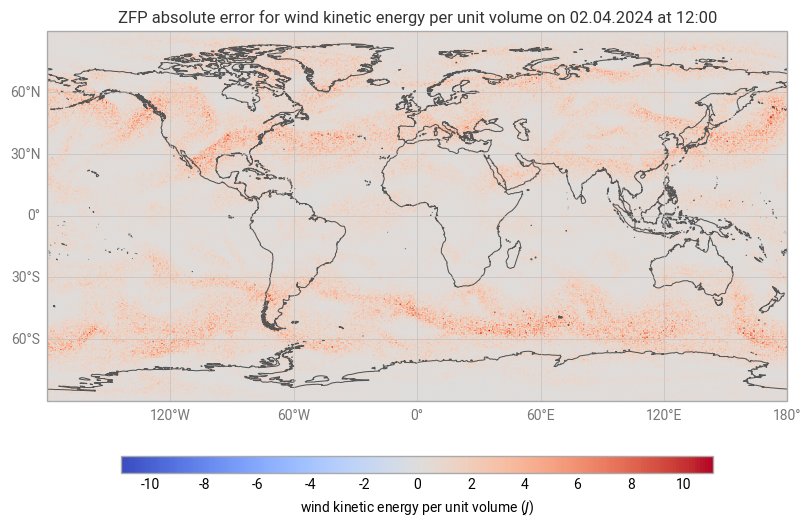

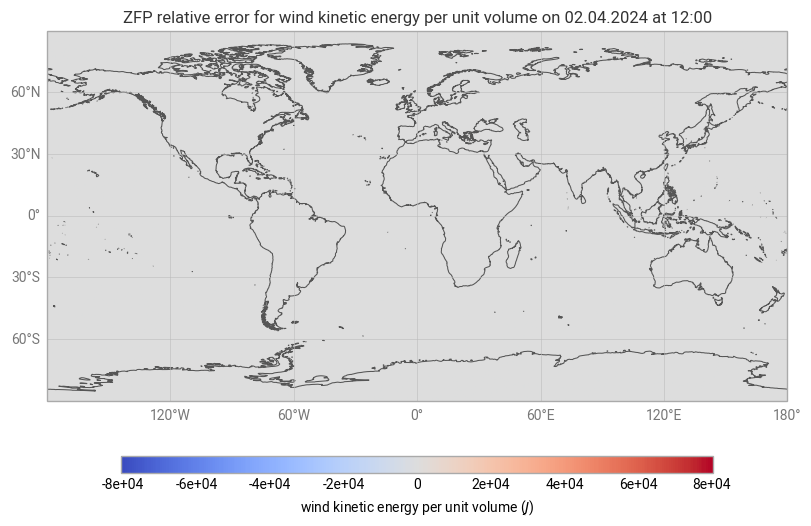

In [15]:
with xr.set_options(keep_attrs=True):
    plot_data(ERA5_KE_zfp - ERA5_KE, error=True, title_prefix="ZFP absolute error for ")
with xr.set_options(keep_attrs=True):
    plot_data(
        (ERA5_KE_zfp - ERA5_KE) / ERA5_KE,
        error=True,
        title_prefix="ZFP relative error for ",
    )

In [16]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [17]:
sg = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi=f"1/2 * {air_mass} * (X[0]**2 + X[1]**2)",
            type="rel",
            eb=0.01,
            neighbourhood=[
                dict(axis=-1, before=0, after=1, boundary="valid"),
            ],
        )
    ],
)

In [18]:
ERA5_UV_sg = sg.decode(sg.encode(ERA5_UV))

In [19]:
np.amax(np.abs(ERA5_UV_sg - ERA5_UV))

np.float32(0.21821213)

In [20]:
ERA5_KE_sg = ERA5_KE.copy(
    data=0.5 * air_mass * (ERA5_UV_sg[..., 0] ** 2 + ERA5_UV_sg[..., 1] ** 2)
)

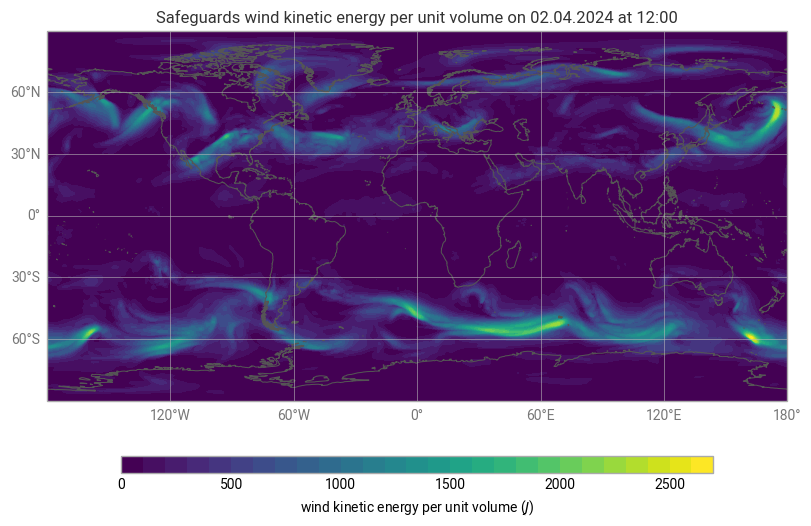

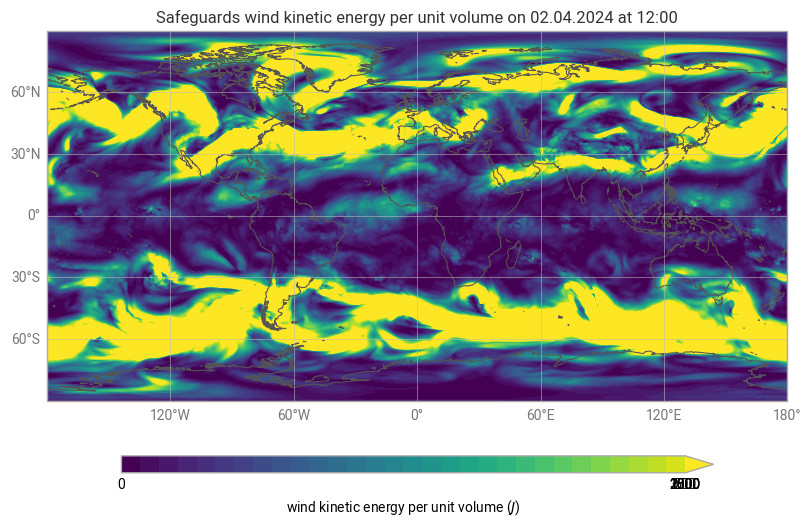

In [21]:
plot_data(
    ERA5_KE_sg,
    levels=np.arange(0, 2700 + 1, 100),
    cmap="viridis",
    title_prefix="Safeguards ",
)
plot_data(
    ERA5_KE_sg,
    levels=np.arange(0, 300 + 1, 10),
    cmap="viridis",
    extend="max",
    title_prefix="Safeguards ",
)

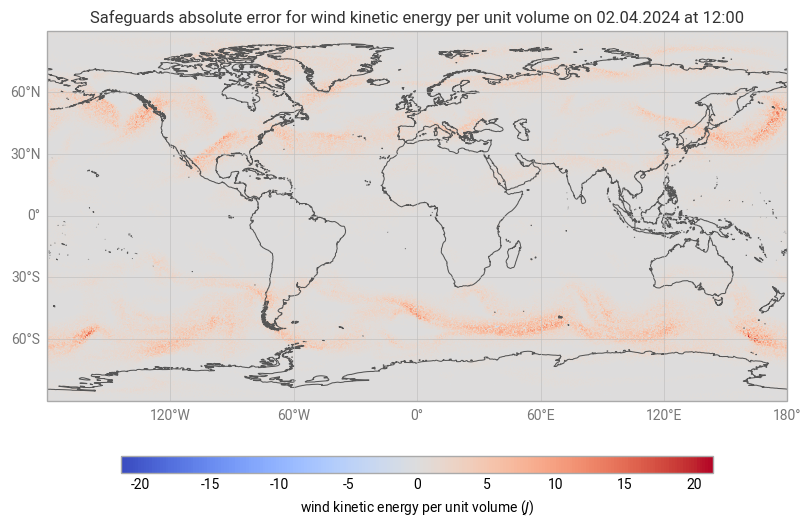

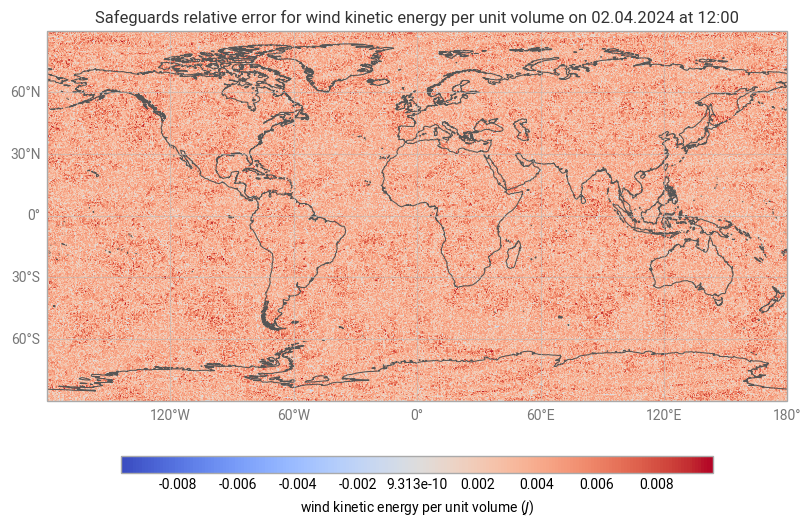

In [22]:
with xr.set_options(keep_attrs=True):
    plot_data(
        ERA5_KE_sg - ERA5_KE, error=True, title_prefix="Safeguards absolute error for "
    )
with xr.set_options(keep_attrs=True):
    plot_data(
        (ERA5_KE_sg - ERA5_KE) / ERA5_KE,
        error=True,
        title_prefix="Safeguards relative error for ",
    )